In [1]:
import pandas as pd
import yfinance as yf
import datetime

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

end_date = datetime.datetime(2023, 7, 16)
start_date = datetime.datetime(2018, 7, 16)

df = yf.download('^GSPC', start=start_date, end=end_date)
print(df.head())

indicepanel = pd.DataFrame(index=df.index)

indicepanel['spy'] = df['Open'].shift(-1) - df['Open']
indicepanel['spy_lag1'] = indicepanel['spy'].shift(1)
indicepanel['sp500'] = df["Open"] - df['Open'].shift(1)
indicepanel['Price'] = df['Open']


[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-07-16  2797.360107  2801.189941  2793.389893  2798.429932  2798.429932   
2018-07-17  2789.340088  2814.189941  2789.239990  2809.550049  2809.550049   
2018-07-18  2811.350098  2816.760010  2805.889893  2815.620117  2815.620117   
2018-07-19  2809.370117  2812.050049  2799.770020  2804.489990  2804.489990   
2018-07-20  2804.550049  2809.699951  2800.010010  2801.830078  2801.830078   

                Volume  
Date                    
2018-07-16  2819860000  
2018-07-17  3064920000  
2018-07-18  3111560000  
2018-07-19  3278360000  
2018-07-20  3243250000  


In [2]:
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

print(indicepanel.isnull().sum())

train = indicepanel.iloc[-1258:-629, :]
test = indicepanel.iloc[-629:, :]

print(train.shape, test.shape)

# Find the indice with the largest correlation
corr_array = train[['spy', 'sp500']].corr()['spy']
print(corr_array)

# Define the formula with only 'sp500' as the predictor for 'spy'
formula = 'spy ~ sp500'

# Fit the model using 'sp500' as the predictor for 'spy'
lm = smf.ols(formula=formula, data=train).fit()

# Print the summary of the model
print(lm.summary())


spy         0
spy_lag1    0
sp500       0
Price       0
dtype: int64
(628, 4) (629, 4)
spy      1.000000
sp500    0.060607
Name: spy, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    spy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.308
Date:                Tue, 18 Jul 2023   Prob (F-statistic):              0.129
Time:                        13:44:22   Log-Likelihood:                -3117.7
No. Observations:                 628   AIC:                             6239.
Df Residuals:                     626   BIC:                             6248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [3]:
# Get the predictions for 'spy' by making copies of the DataFrames
train_copy = train.copy()
test_copy = test.copy()

train_copy['PredictedY'] = lm.predict(train_copy)
test_copy['PredictedY'] = lm.predict(test_copy)

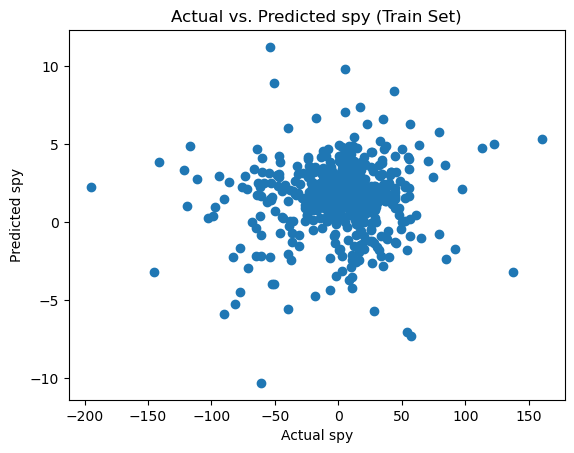

In [4]:
# Plot the scatter plot between the actual 'spy' and predicted 'spy' for Train Set
plt.scatter(train['spy'], train_copy['PredictedY'])
plt.xlabel('Actual spy')
plt.ylabel('Predicted spy')
plt.title('Actual vs. Predicted spy (Train Set)')
plt.show()

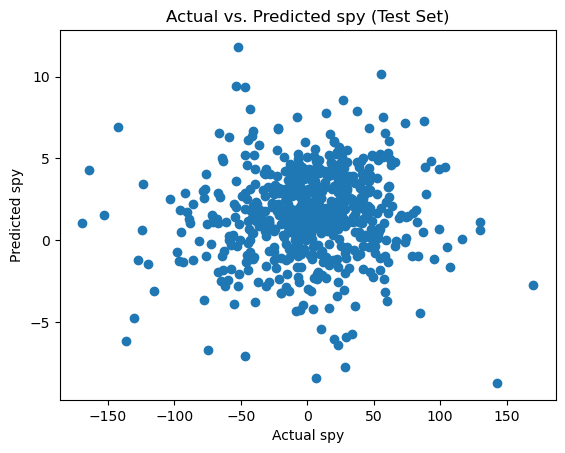

In [5]:
# Plot the scatter plot between the actual 'spy' and predicted 'spy' for Test Set
plt.scatter(test['spy'], test_copy['PredictedY'])
plt.xlabel('Actual spy')
plt.ylabel('Predicted spy')
plt.title('Actual vs. Predicted spy (Test Set)')
plt.show()


In [6]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['PredictedY'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean()) ** 2).sum()
    SSR = ((data['PredictedY'] - data[yname].mean()) ** 2).sum()
    SSE = ((data[yname] - data['PredictedY']) ** 2).sum()
    r2 = SSR / SST
    adjustR2 = 1 - (1 - r2) * (data.shape[0] - 1) / (data.shape[0] - model_k - 1)
    RMSE = (SSE / (data.shape[0] - model_k - 1)) ** 0.5
    return adjustR2, RMSE

def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

# Get the assessment table for the linear regression model using 'sp500' as predictor for 'spy'
assessment_table = assessTable(test, train, lm, 1, 'spy')

print(assessment_table)


          Train       Test
R2     0.002082   0.002171
RMSE  34.716711  44.248959


C:\Users\12367\AppData\Local\Temp\ipykernel_9552\313949180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PredictedY'] = model.predict(data)
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\313949180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PredictedY'] = model.predict(data)


C:\Users\12367\AppData\Local\Temp\ipykernel_9552\3622297349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Order'] = np.where(train['PredictedY'] > 0, 1, -1)
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\3622297349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Profit'] = train['spy'] * train['Order']
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\3622297349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

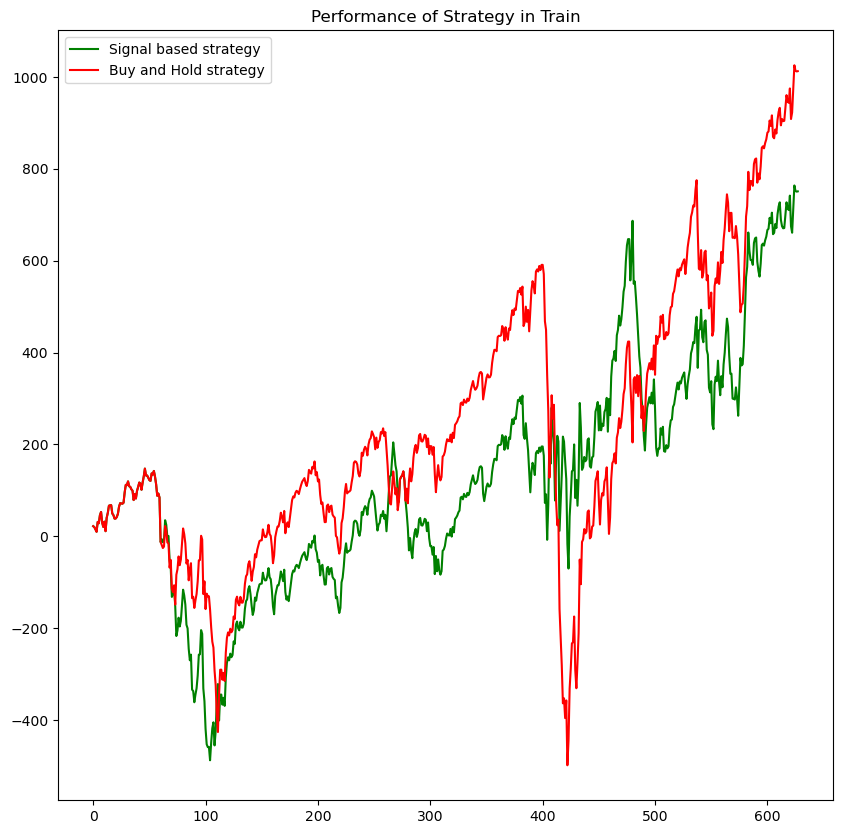

In [10]:
# Profit of Signal-based strategy for train
train['Order'] = np.where(train['PredictedY'] > 0, 1, -1)
train['Profit'] = train['spy'] * train['Order']
train['Wealth'] = train['Profit'].cumsum()
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()

C:\Users\12367\AppData\Local\Temp\ipykernel_9552\2448939356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Order'] = np.where(test['PredictedY'] > 0, 1, -1)
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\2448939356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Profit'] = test['spy'] * test['Order']
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\2448939356.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

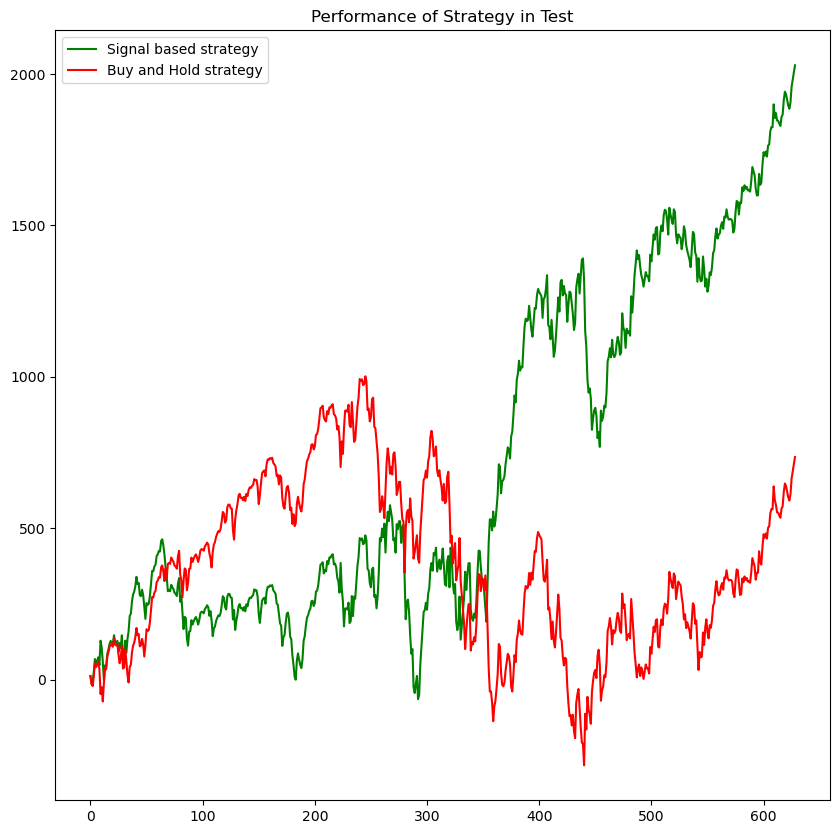

In [9]:
# Profit of Signal-based strategy for test
test['Order'] = np.where(test['PredictedY'] > 0, 1, -1)
test['Profit'] = test['spy'] * test['Order']
test['Wealth'] = test['Profit'].cumsum()

plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()

In [11]:
# Evaluation of model - Practical Standard
train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'Price']
test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'Price']

# Sharpe Ratio on train data
train['Return'] = np.log(train['Wealth']) - np.log(train['Wealth'].shift(1))
dailyr_train = train['Return'].dropna()

print('Daily Sharpe Ratio on Train data:', dailyr_train.mean() / dailyr_train.std(ddof=1))
print('Yearly Sharpe Ratio on Train data:', (252 ** 0.5) * dailyr_train.mean() / dailyr_train.std(ddof=1))


Daily Sharpe Ratio on Train data: 0.030967213405039214
Yearly Sharpe Ratio on Train data: 0.4915892727983968


C:\Users\12367\AppData\Local\Temp\ipykernel_9552\4148157347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'Price']
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\4148157347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'Price']
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\4148157347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [12]:
# Sharpe Ratio on test data
test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))
dailyr_test = test['Return'].dropna()

print('Daily Sharpe Ratio on Test data:', dailyr_test.mean() / dailyr_test.std(ddof=1))
print('Yearly Sharpe Ratio on Test data:', (252 ** 0.5) * dailyr_test.mean() / dailyr_test.std(ddof=1))


Daily Sharpe Ratio on Test data: 0.0675403063813238
Yearly Sharpe Ratio on Test data: 1.0721691249485497


C:\Users\12367\AppData\Local\Temp\ipykernel_9552\3551252411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))


In [13]:
# Maximum Drawdown on train data
train['Peak'] = train['Wealth'].cummax()
train['Drawdown'] = (train['Peak'] - train['Wealth']) / train['Peak']
print('Maximum Drawdown on Train data:', train['Drawdown'].max())


Maximum Drawdown on Train data: 0.21627240040272777


C:\Users\12367\AppData\Local\Temp\ipykernel_9552\3342544155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Peak'] = train['Wealth'].cummax()
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\3342544155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Drawdown'] = (train['Peak'] - train['Wealth']) / train['Peak']


In [14]:
# Maximum Drawdown on test data
test['Peak'] = test['Wealth'].cummax()
test['Drawdown'] = (test['Peak'] - test['Wealth']) / test['Peak']
print('Maximum Drawdown on Test data:', test['Drawdown'].max())

Maximum Drawdown on Test data: 0.14617067511604834


C:\Users\12367\AppData\Local\Temp\ipykernel_9552\1302018873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Peak'] = test['Wealth'].cummax()
C:\Users\12367\AppData\Local\Temp\ipykernel_9552\1302018873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Drawdown'] = (test['Peak'] - test['Wealth']) / test['Peak']
